# Content

- Evaluation des performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.
- Calcul un score avec fp + 10 * fn

precision, recall, accuracy, roc_auc, f1
        fbeta_macro
        fbeta_micro
        fbeta_weighted
        
hyperparameter search for the following methods: XGBoost, LightGBM, Random Forest. Save each model, best parameters and evaluation metrics with MLflow. Save the evaluation metrics for all models to a dataframe.

- [ 0 - Library definition](#0) 
- [ 1 - Data definition](#1) 
- [ 1.1 - Imbalanced Data Definition](#1.1) 
- [ 2 - Metrics definition](#2) 
- [ 3 - Model definition](#3) 
- [ 4 - Run 1 EXPERIMENT with 6 RUNs](#4)
- [ 5 - Model Evaluation](#(5)
- [ 6 - Feature Importance](#(6)

<a name='0'></a>
# 0 Library definition

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import fbeta_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

from prettytable import PrettyTable

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where

<a name='1'></a>
# 1 Data definition

In [3]:
X_train = pd.read_csv('../2_INPUT_DATA/3_SPLIT/X_train.csv')
Y_train = pd.read_csv('../2_INPUT_DATA/3_SPLIT/Y_train.csv')
X_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/X_test.csv')
Y_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/Y_test.csv')
ids_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/ids_test.csv')
feature_names = pd.read_csv('../2_INPUT_DATA/2_FEATURE_PROCESSED/feature_names.csv')

print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("Y_test", Y_test.shape)
print("ids_test",ids_test.shape)
print("feature names", feature_names.shape)

X_train (246008, 239)
Y_train (246008, 1)
Y_test (61503, 1)
ids_test (246008, 1)
feature names (239, 1)


In [ ]:
#test = X_train.copy()
#test["ID"] = ids_test
#test.set_index("ID", inplace=True)
#ids_test.iloc[5]
#test.loc[100008].values.tolist()

<a name='1.1'></a>
# 1.1 Imbalanced Data treatment

In [4]:

def SMOTE_transformation(X, y):
    # summarize class distribution
    counter = Counter(y)
    print(counter)
    # define pipeline
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y)
    print(counter)
    # scatter plot of examples by class label
    #for label, _ in counter.items():
    #    print(label)
    #    row_ix = where(y == label)[0]
    #    print(row_ix)
    #    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        
    #pyplot.legend()
    #pyplot.show()
    
    return X, y

x_train_smote, y_train_smote = SMOTE_transformation(X_train, Y_train['TARGET'])

Counter({0: 226067, 1: 19941})
Counter({0: 45212, 1: 22606})


<a name='2'></a>
# 2 Metrics definition

**Fbeta Score**

![alt text for screen readers](IMAGES/fbetascore.png "Fbeta Score")

A smaller beta value, such as 0.5, gives more weight to precision and less to recall, whereas a larger beta value, such as 2.0, gives less weight to precision and more weight to recall in the calculation of the score.

#### FN et FP  
On simule la supposition, que le coût d’un FN est dix fois supérieur au coût d’un FP.  
On crée un score “métier” en minimisant le coût d’erreur de prédiction des FN et FP pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.

**Precision**  
(tp / (tp + fp))
It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.  

**Recall** is the same as sensitivity.
(tp / (tp + fn)    
Recall describes how good the model is at predicting the positive class when the actual outcome is positive.


We want to optimize recall.

In [125]:
def fbeta_score_calculation(y_true, y_pred):
    fbeta_macro = fbeta_score(y_true, y_pred, average='macro', beta=2)
    fbeta_micro = fbeta_score(y_true, y_pred, average='micro', beta=2)
    fbeta_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2)
    return round(fbeta_macro,2), round(fbeta_micro,2), round(fbeta_weighted,2)

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
def reminder_TP(TN="", FP="", FN="", TP=""):
    #tn, fp, fn, tp
    # Create a PrettyTable instance
    table = PrettyTable()

    # Define columns and headers
    table.field_names = ['Confusion Matrix', 'Positive prediction', 'Negative prediction']

    # Add rows
    table.add_row(['Positive class', 'True positive (TP)', 'False negative (FN)'])
    table.add_row(['Negative class', 'False positive (FP)', 'True negative (TN)'])

    # Print the table
    print(table)
    
    if TN :
        # Create a PrettyTable instance
        table2 = PrettyTable()

        # Define columns and headers
        table2.field_names = ['Confusion Matrix', 'Positive prediction', 'Negative prediction']

        # Add rows
        table2.add_row(['Positive class', TP, FN])
        table2.add_row(['Negative class', FP, TN])

        # Print the table
        print(table2)
    

def generate_recall_precision_curve(model, X_test, Y_test):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
    lr_f1, lr_auc = f1_score(Y_test, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(Y_test[Y_test==1]) / len(Y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    pass

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

def generate_model_report(model, model_name, X_test, Y_test, trainT):
    print("\n---------------------------------")
    print("start generate_model_report")
    
    Y_Test_Pred_best_param = model.predict(X_test)
    
    generate_auc_roc_curve(model, X_test)
    generate_recall_precision_curve(model, X_test, Y_test)
    
    cm = confusion_matrix(np.array(Y_test), Y_Test_Pred_best_param  )
    tn, fp, fn, tp = cm.ravel()
    reminder_TP(tn, fp, fn, tp)
    
    roc_auc = roc_auc_score(np.array(Y_test), Y_Test_Pred_best_param)

    bu_Sc = fp + (10*fn) #business score FN cost 10 times more than fp
    ac_Sc = accuracy_score(np.array(Y_test), Y_Test_Pred_best_param)
    pr_Sc = precision_score(np.array(Y_test), Y_Test_Pred_best_param)
    re_Sc = recall_score(np.array(Y_test), Y_Test_Pred_best_param)
    F1_Sc = f1_score(np.array(Y_test), Y_Test_Pred_best_param)
    fbeta_macro, fbeta_micro, fbeta_weighted = fbeta_score_calculation(np.array(Y_test), Y_Test_Pred_best_param)
    print('ROC AUC: ', roc_auc)
    print("Accuracy = " , accuracy_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Precision = " ,precision_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Recall = " ,recall_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("F1 Score = " ,f1_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Fbeta Score = " ,fbeta_score_calculation(np.array(Y_test), Y_Test_Pred_best_param))
    
    metrics = pd.DataFrame({'model': model_name,'tn': [tn], 'fp': [fp], 'fn': [fn], 'tp': [tp],'FP+10*FN': bu_Sc,
                            'accuracy': [ac_Sc], 
                            'ROC_AUC': [roc_auc],
                            'precision': [pr_Sc],
                            'recall': [re_Sc],
                            'F1_Score': [F1_Sc],
                            'Fbeta_macro':[fbeta_macro], 
                            'Fbeta_micro':[fbeta_micro],
                            'Fbeta_weighted':[fbeta_weighted]
                            })
    print(metrics)
    
    full_threshold_df, metrics_XGB_smote = find_optimal_business_score(model, model_name, X_test, Y_test, trainT)
    
    return metrics_XGB_smote, full_threshold_df 

In [108]:
def find_optimal_business_score(model, model_name, X_test, Y_true, trainT):
    print("---------------------------------")
    print("start find_optimal_business_score")
    predictions_proba = model.predict_proba(X_test)
    
    print("prediction proba", len(predictions_proba))
    print("Y_true", len(Y_true))

    # Threshold values from 0 to 0.5
    threshold_values = [i / 10 for i in range(6)]
    best_B_score = 100000
    
    # Create an empty DataFrame to store results
    results_df = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp', 'FP+10*FN', 'accuracy', 'ROC_AUC', 'precision', 'recall', 'F1_Score', 'Fbeta_macro', 'Fbeta_micro', 'Fbeta_weighted','best'])

    # Loop through threshold values
    for threshold in threshold_values:
        best = 0
        # Convert probabilities to binary predictions based on threshold
        predicted_labels = [1 if x[1] >= threshold else 0 for x in predictions_proba]

        # Calculate confusion matrix and other metrics
        cm = confusion_matrix(Y_true, predicted_labels)
        tn, fp, fn, tp = cm.ravel()
        
        FP_10_FN = fp + 10 * fn
        precision = precision_score(Y_true, predicted_labels)
        recall = recall_score(Y_true, predicted_labels)
        accuracy = accuracy_score(Y_true, predicted_labels)
        roc_auc = roc_auc_score(Y_true, predicted_labels)
        f1 = f1_score(Y_true, predicted_labels)
        fbeta_macro = fbeta_score(Y_true, predicted_labels, beta=2, average='macro')
        fbeta_micro = fbeta_score(Y_true, predicted_labels, beta=2, average='micro')
        fbeta_weighted = fbeta_score(Y_true, predicted_labels, beta=2, average='weighted')

        # best param
        if (best_B_score > FP_10_FN ):
            print(results_df[results_df['best']==1]['best'])
            results_df.loc[(results_df['best']==1),'best']  = 0
            best_B_score = FP_10_FN
            best = 1
        
        
        # Create a DataFrame for the current threshold iteration
        data = {'threshold': [threshold],
                'tn': [tn],
                'fp': [fp],
                'fn': [fn],
                'tp': [tp],
                'FP+10*FN': [FP_10_FN],
                'accuracy': [accuracy],
                'ROC_AUC': [roc_auc],
                'precision': [precision],
                'recall': [recall],
                'F1_Score': [f1],
                'Fbeta_macro': [fbeta_macro],
                'Fbeta_micro': [fbeta_micro],
                'Fbeta_weighted': [fbeta_weighted],
                'best': best
               }

        threshold_df = pd.DataFrame(data)

        # Concatenate the current threshold results to the overall results DataFrame
        results_df = pd.concat([results_df, threshold_df], ignore_index=True)
        
    
    best_result = results_df[results_df['best']==1]
    
    best_metrics = {"TN":best_result["tn"].iloc[0],
                  "FP":best_result["fp"].iloc[0],
                  "FN":best_result["fn"].iloc[0],
                  "TP":best_result["tp"].iloc[0],
                  "FP_10_FN":best_result["FP+10*FN"].iloc[0],
                  "Accuracy": best_result["accuracy"].iloc[0],
                 "F1":best_result["F1_Score"].iloc[0],
                 "Precision":best_result["precision"].iloc[0],
                 "Recall":best_result["recall"].iloc[0],
                 "ROC_AUC":best_result["ROC_AUC"].iloc[0],
                "threshold":best_result["threshold"].iloc[0],
                    "time_in_s":trainT
                 }
    
    print("best b score", best_B_score, results_df[results_df['best']==1]['threshold'])
    print(results_df)
    return results_df, best_metrics

<a name='3'></a>
# 3 Model definition

In [129]:
def RFC_model(X_train, Y_train):
    start = time.time()
    print("START time", time.ctime(start))
    # Define the RandomForestClassifier
    rf_classifier = RandomForestClassifier()

    # Define the hyperparameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, Y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Train the RandomForestClassifier with the best hyperparameters on the entire training set
    best_rf_classifier = RandomForestClassifier(**best_params)
    best_rf_classifier.fit(X_train, Y_train)

    print(f'Best Hyperparameters: {best_params}')

    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    
    return best_rf_classifier, best_params, endT

def train_XGBoost_model(X_train, Y_train):
    
    start = time.time()
    print("START time", time.ctime(start))
    # XGBoost
    xgb_params = {
        'n_estimators': [*range(170, 200, 5)], 
        'max_depth': [6],
        'learning_rate': [0.1],#[0.01,0.05,0.10],
        'subsample': [0.3],#[ 0.3, 0.5 ],
        'colsample_bytree': [0.3]#[ 0.3, 0.5 ],
    }

    xgb_model = XGBClassifier()
    print("start RandomizedSearchCV ")
    xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=100, cv=5, n_jobs=-1, verbose = 6)
    
    xgb_random_search.fit(X_train, Y_train)
    
    # Access the best hyperparameters and the best models
    best_xgb_params = xgb_random_search.best_params_
    best_xgb_model = xgb_random_search.best_estimator_
    
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    return best_xgb_model, best_xgb_params, endT

def train_LightGBM_model(X_train, Y_train):
    # LightGBM
    start = time.time()
    print("START time", time.ctime(time.time()))
    lgbm_params = {
        'boosting_type': ['gbdt'],           # Gradient boosting type
        'n_estimators': [10000],
        'objective': ['binary'],             # Objective function (binary classification)
        'metric': ['binary_logloss'],        # Evaluation metric
        'num_leaves': [31],                  # Maximum number of leaves in one tree
        'learning_rate': [0.05],              # Learning rate
        #'feature_fraction': 0.8,           # Fraction of features used for training each tree
        #'bagging_fraction': 0.8,           # Fraction of samples used for training each tree
        #'bagging_freq': 5,                 # Frequency for bagging, 0 means no bagging
        'class_weight' : ['balanced'],
        'reg_alpha' : [0.1], 
        'reg_lambda' : [0.1], 
        'subsample' : [ 0.8 ]
    }
    # best # best learning_rate = 0.05, #reg_alpha = 0.1, reg_lambda = 0.1, #subsample = 0.8, n_jobs = -1, random_state = 50
    
    lgbm_model = LGBMClassifier()
    lgbm_random_search = RandomizedSearchCV(lgbm_model, param_distributions=lgbm_params, n_iter=50, cv=5, n_jobs=-1, verbose=5)
    lgbm_random_search.fit(X_train, Y_train)

    # Access the best hyperparameters and the best models
    best_lgbm_params = lgbm_random_search.best_params_
    best_lgbm_model = lgbm_random_search.best_estimator_

    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    return best_lgbm_model, best_lgbm_params, endT



**Train models and save model, params to MLflow and the evaluation metrics to a dataframe**

The following command in Terminal to start the MLflow server  
```!mlflow server --host 127.0.0.1 --port 8080```

In [122]:
def run_MLflow(experiment_name, run_name, metrics, params, model_obj, X_train):
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    # Sets the current active experiment to the "LightGBM_Models" experiment and returns the Experiment metadata
    mlflow_experiment = mlflow.set_experiment(experiment_name)

    # Define an artifact path that the model will be saved to.
    artifact_path = run_name+"_artifactPATH"
    print("Artifact PATH" , artifact_path)
    
    # Assemble the metrics we're going to write into a collection
    print(metrics)
    print(params)
    
    signature = infer_signature(X_train, model_obj.predict(X_train))

    # Initiate the MLflow run context
    with mlflow.start_run(run_name=run_name) as run:
        #run = mlflow.active_run()
        print(f"Active run_id: {run.info.run_id}")
        # Log the parameters used for the model fit
        mlflow.log_params(params)
         # Log parameters and metrics with MLflow
        #for key, value in params.items():
        #    mlflow.log_param(key, value)
        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)
        # Log an instance of the trained model for later use
        mlflow.sklearn.log_model(sk_model=model_obj, artifact_path=artifact_path, signature=signature)


<a name='4'></a>
# 4 Run 1 EXPERIMENT with 6 RUNs

**Unbalanced Data**
* Random Forest Classifier RFC
* XGBoost XGB
* LightGBM LGBM

**SMOTE transformed Data**
* Random Forest Classifier RFC
* XGBoost XGB
* LightGBM LGBM

**Initiate MLFlow**

In [54]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080/")
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the credit score project. "
    "This experiment contains the LightGBM, XGboost and RFC model."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "credit-score-classification",
    "store_dept": "Prêt à dépenser",
    "team": "cred-ml",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}

experiment_name = "Credit_scoring"
# Create the Experiment, providing a unique name
experiment = client.create_experiment(name=experiment_name, tags=experiment_tags)

**1/6 RUN XGB with unbalanced data**

start train_XGBoost_model
START time 1709109562.870035
start RandomizedSearchCV 
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 4.7min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 4.4min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 4.7min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 4.4min
endtime 1709110328.2793941  duration 765.4093592166901

---------------------------------
start generate_model_report


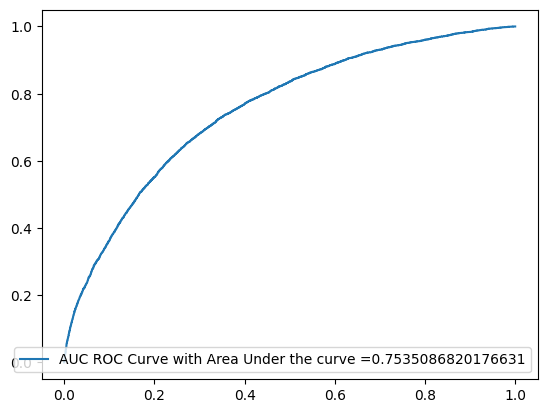

Logistic: f1=0.039 auc=0.233


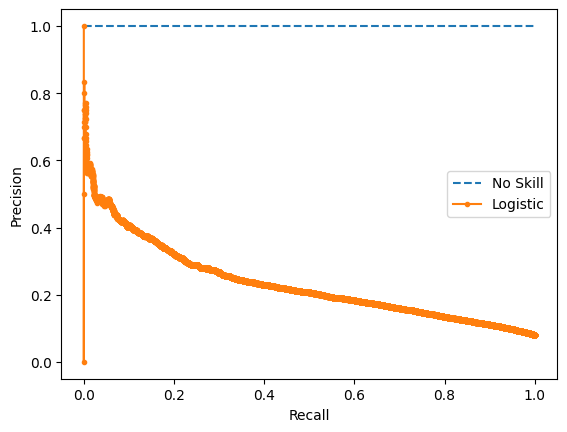

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |          98         |         4786        |
|  Negative class  |          84         |        56535        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5092909595770826
Accuracy =  0.9208168707217534
Precision =  0.5384615384615384
Recall =  0.020065520065520065
F1 Score =  0.038689301223845236
Fbeta Score =  (0.5, 0.92, 0.91)
  model     tn  fp    fn  tp  F

NameError: name 'trainT' is not defined

[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 4.8min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 4.4min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 4.8min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 4.4min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 4.8min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=190, subsample=0.3;, score=0.919 total time= 4.5min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 4.8min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimat

In [107]:
# XGB no SMOTE data   
run_name = "XGB"
print("start train_XGBoost_model")
best_xgb_model, best_xgb_params, timeXGB = train_XGBoost_model(X_train, Y_train)    
run_XGB_metrics  = generate_model_report(best_xgb_model, run_name, X_test, Y_test)
best_metrics_XGB, metrics_XGB = find_optimal_business_score(best_xgb_model, run_name, X_test, Y_test, timeXGB)
signature_XGB    = infer_signature(X_train, best_xgb_model.predict(X_train))
run_MLflow(experiment_name, run_name, metrics_XGB, best_xgb_params, best_xgb_model, signature_XGB)


**2/6 RUN XGB with SMOTE data**

START time Wed Feb 28 10:01:22 2024
start RandomizedSearchCV 
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.727 total time=  59.5s
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.752 total time=  59.9s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.720 total time= 1.0min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.726 total time= 1.1min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.716 total time=  46.7s
START time Wed Feb 28 10:01:22 2024
END time Wed Feb 28 10:04:36 2024  duration 3.245553497473399 min

---------------------------------
start generate_model_report


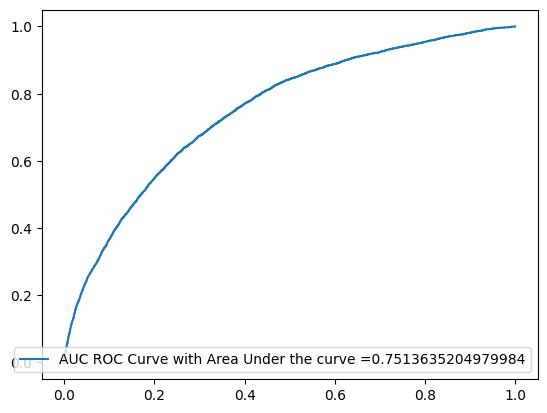

Logistic: f1=0.291 auc=0.232


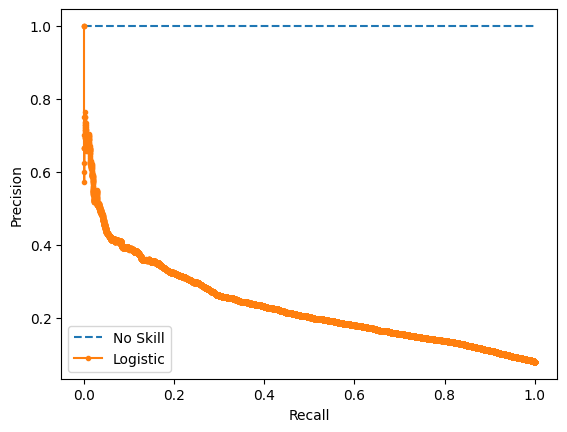

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1834        |         3050        |
|  Negative class  |         5886        |        50733        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6357769201116841
Accuracy =  0.8547062744906753
Precision =  0.23756476683937824
Recall =  0.37551187551187554
F1 Score =  0.29101872421453506
Fbeta Score =  (0.62, 0.85, 0.86)
       model     tn    fp    fn

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Artifact PATH XGB_smote_artifactPATH
{'TN': 38327, 'FP': 18292, 'FN': 1482, 'TP': 3402, 'FP_10_FN': 33112, 'Accuracy': 0.6784872282652878, 'F1': 0.256001204003311, 'Precision': 0.15681755324052735, 'Recall': 0.6965601965601965, 'ROC_AUC': 0.6867442180985338, 'threshold': 0.3, 'time_in_s': 194.73320984840393}
{'subsample': 0.3, 'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
Active run_id: ecaf399e6500430c9377d5baf31e5f8e
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.719 total time= 1.1min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.714 total time= 1.1min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.752 total time= 1.0min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.753 total time= 1.1min
[CV 4/5] EN

In [114]:
# XGB with SMOTE data   
run_name = "XGB_smote"
XGB_model_smote, best_xfb_params_smote, timeXGBsmote =  train_XGBoost_model(x_train_smote, y_train_smote)
XGB_smote_metrics     = generate_model_report(XGB_model_smote, run_name, X_test, Y_test)
best_metrics_XGB_smote, metrics_XGB_smote = find_optimal_business_score(XGB_model_smote, run_name, X_test, Y_test, timeXGBsmote)
signature_XGB_smote     = infer_signature(X_train, best_xgb_model.predict(X_train))
run_MLflow(experiment_name, run_name, metrics_XGB_smote, best_xfb_params_smote, XGB_model_smote, signature_XGB_smote)

**3/6 LightGBM on unbalanced data set**

START time Wed Feb 28 10:59:29 2024
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11501
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
START time Wed Feb 28 10:59:29 2024
END time Wed Feb 28 11:07:48 2024  duration 8.324515279134115 min

---------------------------------
start generate_model_report


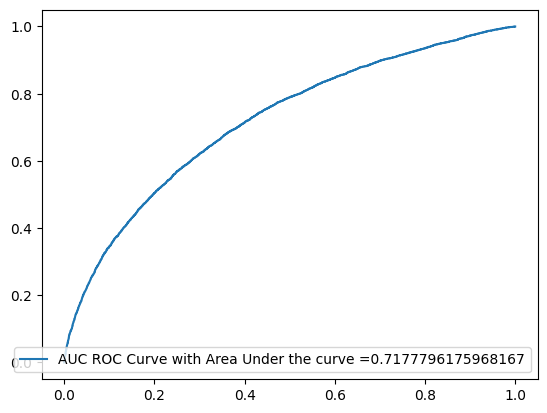

Logistic: f1=0.268 auc=0.207


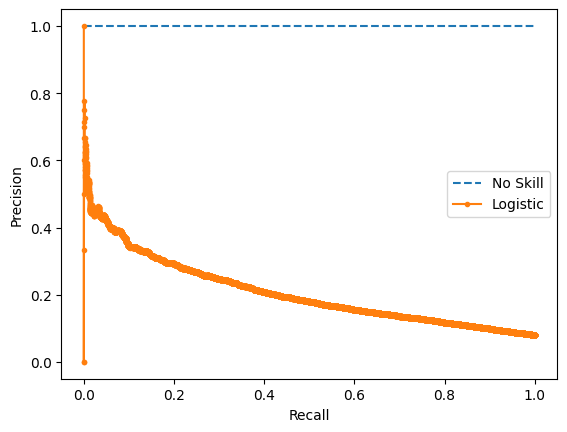

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1389        |         3495        |
|  Negative class  |         4105        |        52514        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6059479354066859
Accuracy =  0.8764287920914426
Precision =  0.25282125955587914
Recall =  0.2843980343980344
F1 Score =  0.26768163422624786
Fbeta Score =  (0.6, 0.88, 0.88)
      model     tn    fp    fn   

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Artifact PATH LightGBM_artifactPATH
{'TN': 41184, 'FP': 15435, 'FN': 1998, 'TP': 2886, 'FP_10_FN': 35415, 'Accuracy': 0.7165504121750158, 'F1': 0.24873949579831933, 'Precision': 0.157524152611757, 'Recall': 0.5909090909090909, 'ROC_AUC': 0.659148711723819, 'threshold': 0.2, 'time_in_s': 499.4709167480469}
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 10000, 'metric': 'binary_logloss', 'learning_rate': 0.05, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}
Active run_id: 626326a511304ac2aee373ba9aa7ecf7
[LightGBM] [Info] Number of positive: 15952, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11420
[LightGBM] [Info] Number of data points in the train set: 196806, number of used feature

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11495
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 2/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.883 total time= 6.6min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11406
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 3/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.886 total time= 6.7min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11428
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 5/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.886 total time= 7.2min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11491
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 4/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.885 total time= 7.2min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [116]:
run_name = "LightGBM"
LGBM_model, best_LGBM_params, time_LGBM =  train_LightGBM_model(X_train, Y_train)
LGBM_metrics     = generate_model_report(LGBM_model, run_name, X_test, Y_test)
best_metrics_LGBM, metrics_LGBM = find_optimal_business_score(LGBM_model, run_name, X_test, Y_test, time_LGBM)
signature_LGBM     = infer_signature(X_train, LGBM_model.predict(X_train))
run_MLflow(experiment_name, run_name, metrics_LGBM, best_LGBM_params, LGBM_model, signature_LGBM)

**4/6 LightGBM on smote data set**

START time Wed Feb 28 13:19:30 2024
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22606, number of negative: 45212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15832
[LightGBM] [Info] Number of data points in the train set: 67818, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
START time Wed Feb 28 13:19:30 2024
END time Wed Feb 28 13:24:32 2024  duration 5.034470983346304 min

---------------------------------
start generate_model_report


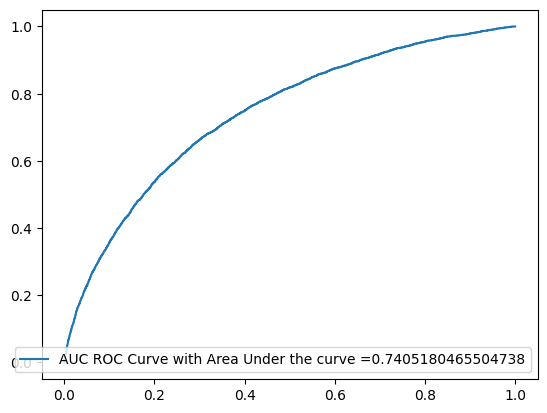

Logistic: f1=0.285 auc=0.215


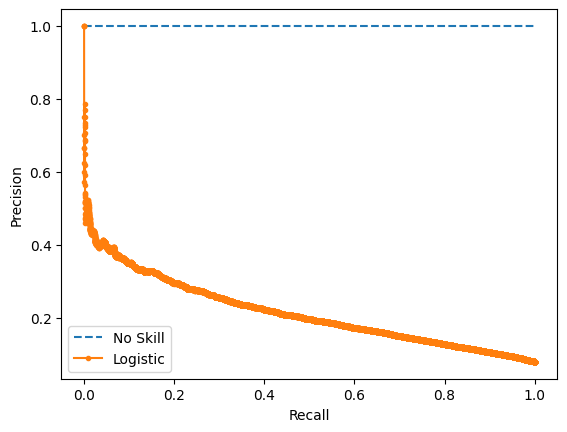

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         2304        |         2580        |
|  Negative class  |         8978        |        47641        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6565878966928085
Accuracy =  0.8120742077622229
Precision =  0.20421911008686403
Recall =  0.47174447174447176
F1 Score =  0.2850426821724607
Fbeta Score =  (0.62, 0.81, 0.82)
            model     tn    fp  

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Artifact PATH LightGBM_smote_artifactPATH
{'TN': 41184, 'FP': 15435, 'FN': 1998, 'TP': 2886, 'FP_10_FN': 35415, 'Accuracy': 0.7165504121750158, 'F1': 0.24873949579831933, 'Precision': 0.157524152611757, 'Recall': 0.5909090909090909, 'ROC_AUC': 0.659148711723819, 'threshold': 0.2, 'time_in_s': 302.0682590007782}
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 10000, 'metric': 'binary_logloss', 'learning_rate': 0.05, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}
Active run_id: 5392693623854f9bab8fa86a3492992c
[LightGBM] [Info] Number of positive: 18085, number of negative: 36170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10944
[LightGBM] [Info] Number of data points in the train set: 54255, number of used fea

In [121]:
run_name = "LightGBM_smote"
LGBM_smote_model, best_LGBM_smote_params, time_LGBM_smote =  train_LightGBM_model(x_train_smote, y_train_smote)
LGBM_smote_metrics     = generate_model_report(LGBM_smote_model, run_name, X_test, Y_test)
best_metrics_LGBM_smote, metrics_LGBM_smote = find_optimal_business_score(LGBM_model, run_name, X_test, Y_test, time_LGBM_smote)
signature_LGBM_smote     = infer_signature(X_train, LGBM_smote_model.predict(x_train_smote))
run_MLflow(experiment_name, run_name, metrics_LGBM_smote, best_LGBM_smote_params,
           LGBM_smote_model, signature_LGBM_smote)

**5/6 RFC on unbalanced data set**

In [ ]:
run_name = "RFC"
RFC_model, best_RFC_params, time_RFC = RFC_model(X_train, Y_train)
RFC_metrics, best_metrics_RFC        = generate_model_report(RFC_model, run_name, X_test, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model, X_train)

START time Thu Feb 29 11:07:31 2024


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

**6/6 RFC on Smote data set**

START time Thu Feb 29 10:41:45 2024


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
START time Thu Feb 29 10:41:45 2024
END time Thu Feb 29 11:06:55 2024  duration 25.16940438747406 min

---------------------------------
start generate_model_report


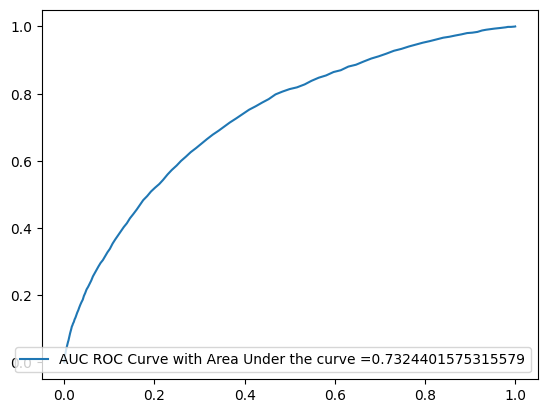

Logistic: f1=0.252 auc=0.211


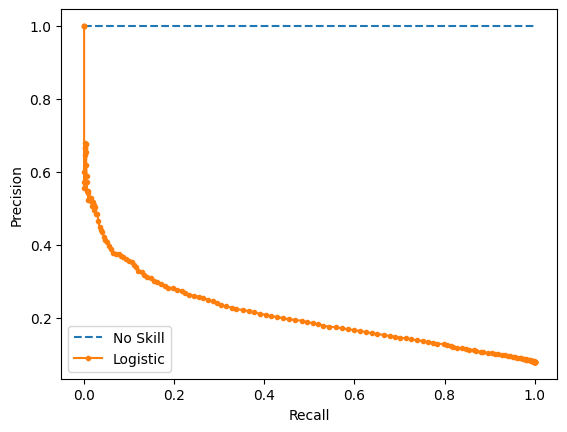

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1192        |         3692        |
|  Negative class  |         3392        |        53227        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5920765131542431
Accuracy =  0.8848186267336553
Precision =  0.2600349040139616
Recall =  0.24406224406224405
F1 Score =  0.251795521757499
Fbeta Score =  (0.59, 0.88, 0.88)
       model     tn    fp    fn   

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Active run_id: b847bbc297a34b9ebd42cc3d7c4254f5


In [132]:
run_name = "RFC_smote"
RFC_model_smote, best_RFC_params_smote, time_RFC_smote = RFC_model(x_train_smote, y_train_smote)
RFC_smote_metrics, best_metrics_RFC_smote              = generate_model_report(RFC_model_smote, run_name, X_test, Y_test, time_RFC_smote)
run_MLflow(experiment_name, run_name, RFC_smote_metrics, 
           best_RFC_params_smote, RFC_model_smote, x_train_smote)

<a name='4'></a>
# 5 Evalutation and selection of best model

<a name='4'></a>
# 6 Feature Importance

In [11]:
feature_names.iloc[:,0].values.tolist()

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG'

In [12]:
# Accessing feature importance
feature_importance = RFC_model.feature_importances_

# Printing feature importance for each feature
for i, feature_name in enumerate(feature_names.iloc[:,0].values.tolist()):
    print(f'Feature: {feature_name}, Importance: {feature_importance[i]}')

Feature: NAME_CONTRACT_TYPE, Importance: 0.0018297758015853526
Feature: FLAG_OWN_CAR, Importance: 0.0030586575734834463
Feature: FLAG_OWN_REALTY, Importance: 0.0033499665571412934
Feature: CNT_CHILDREN, Importance: 0.006634875297286168
Feature: AMT_INCOME_TOTAL, Importance: 0.02468931882005001
Feature: AMT_CREDIT, Importance: 0.028422053024290152
Feature: AMT_ANNUITY, Importance: 0.030261678534354446
Feature: AMT_GOODS_PRICE, Importance: 0.0242600434287482
Feature: REGION_POPULATION_RELATIVE, Importance: 0.02352804096539262
Feature: DAYS_BIRTH, Importance: 0.03603407862980179
Feature: DAYS_EMPLOYED, Importance: 0.0309055044687784
Feature: DAYS_REGISTRATION, Importance: 0.033540991954743055
Feature: DAYS_ID_PUBLISH, Importance: 0.03470452212577097
Feature: OWN_CAR_AGE, Importance: 0.012540301988614808
Feature: FLAG_MOBIL, Importance: 0.0
Feature: FLAG_EMP_PHONE, Importance: 0.000993853837077491
Feature: FLAG_WORK_PHONE, Importance: 0.0032851052667167533
Feature: FLAG_CONT_MOBILE, Import

In [13]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names.iloc[:,0].values.tolist(),
    'Importance': RFC_model.feature_importances_
})

# Sorting the DataFrame by importance scores
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Displaying the sorted DataFrame
#print(feature_importance_df_sorted.head(20))
feature_importance_df_sorted['Feature'][:20].tolist()


['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_1',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'TOTALAREA_MODE',
 'LIVINGAREA_MODE']

In [14]:
explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(data_point)
shap_df = pd.DataFrame({'Feature': X.columns, 'SHAP Value': shap_values[0]})
print("\nSHAP Values:")
print(shap_df)


In [ ]:
#!pip freeze > requirements.txt

## Test MLflow on Fastapi model serving

In [ ]:
!curl http://127.0.0.1:8000/predict -H 'Content-Type: application/json' -d '{"inputs": [[0, 0, 1, 1, 63000.0, 310500.0, 15232.5, 310500.0, 0.026392, 16263, -214.0, -8930.0, -573, 0.0, 1, 1, 0, 1, 1, 0, 2.0, 2, 2, 11, 0, 0, 0, 0, 1, 1, 0.0, 0.0765011930557638, 0.0005272652387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, false, false, false, false, true, false, false, false, true, false, false, true, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]]}'
  

In [ ]:
!curl http://127.0.0.1:8000/predict -H 'Content-Type: application/json' -d '{"data_point": [[0, 0, 1, 1, 63000.0, 310500.0, 15232.5, 310500.0, 0.026392, 16263, -214.0, -8930.0, -573, 0.0, 1, 1, 0, 1, 1, 0, 2.0, 2, 2, 11, 0, 0, 0, 0, 1, 1, 0.0, 0.0765011930557638, 0.0005272652387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, false, false, false, false, true, false, false, false, true, false, false, true, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]]}'


**Conversion of type of the test data**

In [ ]:
# Select columns with data type 'int64'
int_columns = X_train.select_dtypes(include=['int64']).columns

# Convert selected columns to int
X_train[int_columns] = X_train[int_columns].astype('float')
# Select columns with data type 'int64'
int_columns = X_train.select_dtypes(include=['bool']).columns

# Convert selected columns to int
X_train[int_columns] = X_train[int_columns].astype('float')
X_train.info()

**Selection of a data point for testing**

In [ ]:
test = X_train.copy()
test["ID"] = ids_test
test.set_index("ID", inplace=True)
ids_test.iloc[5]
#test.loc[100008].values.tolist()
data_for_request = test.loc[100030].values.tolist()

In [ ]:
#data_for_request

In [ ]:
import requests

# initialised with: mlflow models serve -m model_LGBM02/ --port 8092
#http://127.0.0.1:8092

host = '127.0.0.1'
port = '8000'

# endpoint
url = f'http://{host}:{port}/predict'
print("URI : ", url)
headers = {
    'Content-Type': 'application/json',
}

headers = {'Content-Type': 'application/json'}

# Send the POST request with the data
response = requests.post(url, json={"data_point": data_for_request})

print(f'Predictions: {response.text}')

**TEST with empty data set**

In [ ]:
# Send the POST request with the data
response = requests.post(url, json={"data_point":[]})

print(f'Predictions: {response.text}')

**TEST on hosting environment**

In [ ]:
url = 'https://fastapi-cd-webapp.azurewebsites.net/predict'
# Send the POST request with the data
response = requests.post(url, json={"data_point": data_for_request})

print(f'Predictions: {response.text}')